<a href="https://colab.research.google.com/github/mechamrit/ML-DeepLearning/blob/master/001_Course_01_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression with a Neural Network mindset**

---



**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

In [0]:
train_file_link = 'https://drive.google.com/open?id=10Pg940T3ye-GPAK-mIHG992zhamqle2l'
test_file_link = 'https://drive.google.com/open?id=1u2NDR0TRO6UR33NfsYwYomjudjsF7vdM'



For installing from the GDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage


file_train = h5py.File('drive/My Drive/Dataset/CatvsNonCat/train_catvnoncat.h5','r')
display(file_train['train_set_x'][0].shape)
display(file_train['list_classes'])
display(file_train['train_set_y'][0])

(64, 64, 3)

<HDF5 dataset "list_classes": shape (2,), type "|S7">

0

In [5]:
list(file_train.keys())

['list_classes', 'train_set_x', 'train_set_y']

In [0]:
def load_data():
  train_dataset = h5py.File('drive/My Drive/Dataset/CatvsNonCat/train_catvnoncat.h5','r')
  train_set_x_orig = np.array(train_dataset["train_set_x"][:])
  train_set_y_orig = np.array(train_dataset['train_set_y'][:])

  test_dataset = h5py.File('drive/My Drive/Dataset/CatvsNonCat/test_catvnoncat.h5','r')
  test_set_x_orig = np.array(test_dataset["test_set_x"][:])
  test_set_y_orig = np.array(test_dataset["test_set_y"][:])

  classes = np.array(test_dataset["list_classes"][:])

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig,test_set_y_orig ,classes

  

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of m_train images labeled as cat (y=1) or non-cat (y=0)
    - a test set of m_test images labeled as cat or non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Load the data by running the following code.

In [0]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_data()

We added "_orig" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with train_set_x and test_set_x (the labels train_set_y and test_set_y don't need any preprocessing).

Each line of your train_set_x_orig and test_set_x_orig is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

y = [0], it's a 'non-cat' picture.


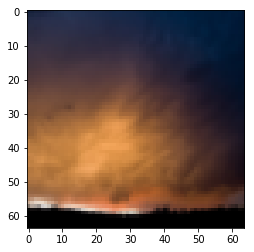

In [8]:
## Examples of Picture
index = 0
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)
    - num_px (= height = width of a training image)
Remember that `train_set_x_orig` is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access `m_train` by writing `train_set_x_orig.shape[0]`.

In [9]:
display(train_set_x_orig.shape)
display(test_set_x_orig.shape)
## Here 209 and 50 are number of examples num_px = 64
display(train_set_y.shape)
display(test_set_y.shape)

(209, 64, 64, 3)

(50, 64, 64, 3)

(1, 209)

(1, 50)

In [10]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Number of examples of trainining and test resp",m_train,'and',m_test)



Number of examples of trainining and test resp 209 and 50


For convenience, you should now reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.

**Exercise:** Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num\_px $*$ num\_px $*$ 3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b$*$c$*$d, a) is to use: 
```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```

In [11]:
## Flattening the examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

## Shapes After Flattening
display(train_set_x_flatten.shape,test_set_x_flatten.shape)


64*64*3

(12288, 209)

(12288, 50)

12288

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

<!-- During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures. !--> 

Let's standardize our dataset.

In [0]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

<font color='blue'>
**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, num_px, ...)
- Reshape the datasets such that each example is now a vector of size (num_px \* num_px \* 3, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**



**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions. Use np.exp().

In [0]:
## Sigmoid Function
def sigmoid(z):
  s = 1/(1+np.exp(-z))
  return s

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [0]:
def initialize_with_zeros(dim):
  w = np.zeros((dim,1))
  b = 0
  return w,b
  

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [0]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X)+b)  ;                               # compute activation
    cost = -(np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1-A).T))/m                         # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = np.dot(X,(np.subtract(A,Y).T))/m
    db = np.sum(A-Y)/m
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [0]:
def optimize(w,b,X,Y,num_iterations,learning_rate,print_cost=False):
    costs=[]
    for i in range(num_iterations):
        grads,cost = propagate(w,b,X,Y)
        dw = grads["dw"]
        db = grads["db"]

        w -= learning_rate * dw
        b -= learning_rate * db

        ## Recording the Cost
        if (i%100) == 0:
            costs.append(cost)
        if print_cost and i % 100 ==0:
            print("Cost after iterations %i is %f"%(i,cost))
            
    params = { "w":w , "b":b} 
    grads = {"dw":dw , "db":db}

    return params,grads,costs


**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [0]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
 
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
  
        if(A[0,i]< 0.5):
            Y_prediction[0,i] = 0
            
        else:
            Y_prediction[0,i] = 1
    
    return Y_prediction

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [0]:
def model(X_train ,Y_train, X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False ):
    w , b = initialize_with_zeros(X_train.shape[0])
    ## Gradient Descsent
    parameters , grads , costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate, print_cost)

    ## Retreive w and b
    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d


In [19]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iterations 0 is 0.693147
Cost after iterations 100 is 0.584508
Cost after iterations 200 is 0.466949
Cost after iterations 300 is 0.376007
Cost after iterations 400 is 0.331463
Cost after iterations 500 is 0.303273
Cost after iterations 600 is 0.279880
Cost after iterations 700 is 0.260042
Cost after iterations 800 is 0.242941
Cost after iterations 900 is 0.228004
Cost after iterations 1000 is 0.214820
Cost after iterations 1100 is 0.203078
Cost after iterations 1200 is 0.192544
Cost after iterations 1300 is 0.183033
Cost after iterations 1400 is 0.174399
Cost after iterations 1500 is 0.166521
Cost after iterations 1600 is 0.159305
Cost after iterations 1700 is 0.152667
Cost after iterations 1800 is 0.146542
Cost after iterations 1900 is 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


## Surely Model is overfitting

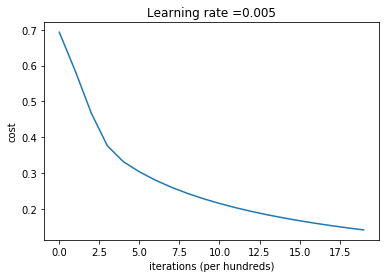

In [20]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------

learning rate is: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


train accuracy: 100.0 %
test accuracy: 72.0 %

-------------------------------------------------------

learning rate is: 0.6
train accuracy: 100.0 %
test accuracy: 72.0 %

-------------------------------------------------------



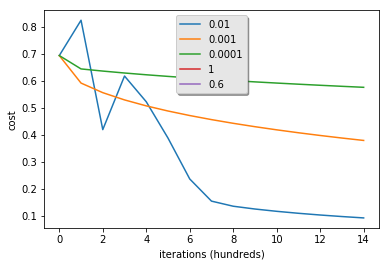

In [21]:
learning_rates = [0.01, 0.001, 0.0001 ,1 ,0.6]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

# Logistic Regression Using TensorFlow

In [0]:
import tensorflow as tf

In [23]:
## Reviewing the shape 
display(np.transpose(train_set_x).shape , np.transpose(train_set_y).shape)

(209, 12288)

(209, 1)

In [0]:
n = train_set_x.shape[0]
train_set_x = np.transpose(train_set_x)
#train_set_y = np.transpose(train_set_y)

In [0]:
X = tf.placeholder(tf.float32 , [None,12288])
Y = tf.placeholder(tf.float32 , [None ,1])
W = tf.Variable(tf.zeros([12288,1]))
b = tf.Variable(tf.zeros([1]))

In [0]:
# alpha, epochs = 0.001, 400
test_set_x = np.transpose(test_set_x)
# test_set_y = np.transpose(test_set_y)

In [27]:
(train_set_y).shape

(1, 209)

In [28]:
mod = (tf.add(tf.matmul(X, W), b))

# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=Y))


# Define the learning rate， batch_size etc.
learning_rate = 0.003
batch_size = 30
iter_num = 1500

# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

# Define the goal
goal = opt.minimize(loss)

# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, Y), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework


# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []


init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(int(train_set_x.shape[0]), size=batch_size)
    batch_train_X = train_set_x[batch_index]
    batch_train_y = np.matrix(train_set_y[:,batch_index]).T
    sess.run(goal, feed_dict={X: batch_train_X, Y: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={X: batch_train_X, Y: batch_train_y})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={X: train_set_x, Y: np.transpose(train_set_y)})
    temp_test_acc = sess.run(accuracy, feed_dict={X: test_set_x, Y: np.transpose(test_set_y)})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))






W0829 05:11:15.042554 140716052453248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch:  300 loss: 0.372404 train_acc: 0.751196 test_acc: 0.500000
epoch:  600 loss: 0.245490 train_acc: 0.894737 test_acc: 0.800000
epoch:  900 loss: 0.261604 train_acc: 0.846890 test_acc: 0.500000
epoch: 1200 loss: 0.221878 train_acc: 0.947368 test_acc: 0.780000
epoch: 1500 loss: 0.209129 train_acc: 0.961722 test_acc: 0.740000


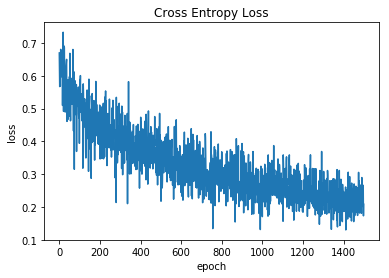

In [29]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

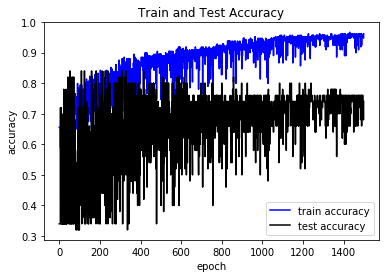

In [30]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()